In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
import os
os.chdir('drive/MyDrive/Colab Notebooks/histopathology-cancer-classification')
sys.path.append('src')

In [3]:
!ls

 data			      README.md
 Graph_MIL.ipynb	     'Sean-testing-Copy of graph-neural-network.ipynb'
 graph-neural-network.ipynb   src
 model_checkpoint.pt	      trained


In [4]:
import data
import utils
import config
import model

In [5]:
from importlib import reload

def reload_all():
    reload(data)
    reload(utils)
    reload(config)
    reload(model)

In [6]:
config.args

{'data': {'dev': {'LUAD': 'data/extracteddevfeatures/extracted_features_LUAD_dev.pickle',
   'LUSC': 'data/extracteddevfeatures/extracted_features_LUSC_dev.pickle',
   'MESO': 'data/extracteddevfeatures/extracted_features_MESO_dev.pickle'},
  'train': {'LUAD': 'data/extractedtrainfeatures/extracted_features_LUAD.pickle',
   'LUSC': 'data/extractedtrainfeatures/extracted_features_LUSC.pickle',
   'MESO': 'data/extractedtrainfeatures/extracted_features_MESO_256.pickle'}},
 'max_patch_count': 10,
 'model_output_dir': 'trained/',
 'num_dev_sets': 11,
 'num_train_sets': {'LUAD': 10000, 'LUSC': 10000, 'MESO': 10000},
 'num_val_sets': {'LUAD': 1000, 'LUSC': 1000, 'MESO': 1000},
 'seed': 647}

In [7]:
device = utils.get_device()

Current device: cuda


In [8]:
from torch.utils.data import Dataset

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pylab as plt

## EDA

All WSIs

In [10]:
# all_patches = []

In [11]:
# for ds_type in ['train', 'dev']:
#     for label in os.listdir('data/{}/'.format(ds_type)):
#         for wsi_name in os.listdir('data/{}/{}/'.format(ds_type, label)):
#             all_patches.append({
#                 'type' : ds_type,
#                 'label' : label,
#                 'wsi_name' : wsi_name,
#                 'num_patches' : len(os.listdir('data/{}/{}/{}/'.format(ds_type, label, wsi_name)))
#             })

In [12]:
# df = pd.DataFrame(all_patches)

Number of WSIs in each category

In [13]:
# pd.pivot_table(
#     df,
#     values=['wsi_name', 'num_patches'],
#     index=['type', 'label'],
#     aggfunc={
#         'wsi_name' : np.count_nonzero,
#         'num_patches' : [np.min, np.max, np.mean]
#     }
# )

In [14]:
# np.percentile(df['num_patches'], [2, 5, 10, 25, 50, 70, 90, 95])

In [15]:
# np.percentile(df.loc[df['type'] == 'train']['num_patches'], [2, 5, 10, 25, 50, 70, 90, 95])

In [16]:
# np.percentile(df.loc[df['type'] == 'dev']['num_patches'], [2, 5, 10, 25, 50, 70, 90, 95])

In [17]:
# df.loc[(df['type'] == 'train') & (df['label'] == 'MESO')]

In [18]:
# df.loc[(df['type'] == 'dev') & (df['label'] == 'MESO')]

Number of patches distribution

In [19]:
# # train
# sns.histplot(
#     data=df.loc[df['type'] == 'train'],
#     x='num_patches',
#     hue='label'
# )

# plt.show()

In [20]:
# # dev
# sns.histplot(
#     data=df.loc[df['type'] == 'dev'],
#     x='num_patches',
#     hue='label'
# )

# plt.show()

## Set-up

In [21]:
# !python -c "import torch; print(torch.__version__)"

In [22]:
# !pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.1+cu101.html
# !pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.1+cu101.html
# !pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.8.1+cu101.html
# !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.8.1+cu101.html
# !pip install torch-geometric

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torch_geometric.nn import GCNConv, SAGPooling,GlobalAttention,global_add_pool,SAGEConv,ChebConv,GraphConv,graclus, global_mean_pool
import numpy as np
# from torch_geometric import data 
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torch.nn.init
import pickle

from collections import Counter

## Data

In [24]:
features = {}
for ftype in ['train', 'dev']:
    features[ftype] = {}
    for flabel in ['LUAD', 'LUSC', 'MESO']:
        file_path = config.args['data'][ftype][flabel]
        print(file_path)
        features[ftype][flabel] = data.load_features(ftype, flabel, file_path)

data/extractedtrainfeatures/extracted_features_LUAD.pickle
data/extractedtrainfeatures/extracted_features_LUSC.pickle
data/extractedtrainfeatures/extracted_features_MESO_256.pickle
data/extracteddevfeatures/extracted_features_LUAD_dev.pickle
data/extracteddevfeatures/extracted_features_LUSC_dev.pickle
data/extracteddevfeatures/extracted_features_MESO_dev.pickle


In [25]:
wsi_counts = {}
for ftype in ['train', 'dev']:
    wsi_counts[ftype] = {}
    for flabel in ['LUAD', 'LUSC', 'MESO']:
        wsi_counts[ftype][flabel] = len(features[ftype][flabel])

print(wsi_counts)

{'train': {'LUAD': 72, 'LUSC': 156, 'MESO': 9}, 'dev': {'LUAD': 38, 'LUSC': 41, 'MESO': 5}}


In [26]:
utils.set_seed()

train_features = []
train_labels = []

for i, flabel in enumerate(['LUAD', 'LUSC', 'MESO']):
    sample_features = data.get_sample_features(
        features['train'][flabel],
        config.args['num_train_sets'][flabel],
        config.args['max_patch_count']
    )
    train_features.extend(sample_features)
    train_labels.extend([i] * len(sample_features))

assert len(train_features) == len(train_labels)

In [27]:
utils.set_seed()

val_features = []
val_labels = []

for i, flabel in enumerate(['LUAD', 'LUSC', 'MESO']):
    sample_features = data.get_sample_features(
        features['train'][flabel],
        config.args['num_val_sets'][flabel],
        config.args['max_patch_count']
    )
    val_features.extend(sample_features)
    val_labels.extend([i] * len(sample_features))

assert len(val_features) == len(val_labels)

In [28]:
print("Training set has {} set of patches. Validation set has {} set of patches.".format(
    len(train_features),
    len(val_features)
))

Training set has 30112 set of patches. Validation set has 3110 set of patches.


In [29]:
Counter(train_labels)

Counter({0: 10031, 1: 10077, 2: 10004})

In [30]:
Counter(val_labels)

Counter({0: 1033, 1: 1073, 2: 1004})

In [31]:
train_features_padded = data.pad_features(train_features, config.args['max_patch_count'])

In [32]:
train_features_padded.shape

(30112, 10, 1024)

In [33]:
val_features_padded = data.pad_features(val_features, config.args['max_patch_count'])

In [34]:
val_features_padded.shape

(3110, 10, 1024)

In [35]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

## Model

In [36]:
class fe_extrator(nn.Module):
    
    '''
    This is actually the second feature extractor.
    In paper: page7 "we further feed DenseNet features through three dense layers with dropout p = 0.5"
    I got the first feature extractor in another notebook.
    '''

    def __init__(self):
        super(fe_extrator, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.fc1=nn.Linear(1024, 784)
        self.fc2=nn.Linear(784, 512)
        self.fc3=nn.Linear(512, 512)
        self.d=nn.Dropout(0.5)

    def forward(self,x):
        
        # Not sure what mask is doing here 
        mask = (x.sum(-1) != 0).type(torch.DoubleTensor)
        mask = mask.unsqueeze(-1).to(device)
        
        x=self.fc1(x)
        x=self.d(x)
        x= F.relu(x)
        x = x * mask
        
        x=self.fc2(x)
        x=self.d(x)
        x= F.relu(x)
        x = x * mask
                
        x=self.fc3(x)
        x=self.d(x)
        x= F.relu(x)
        x = x * mask
        
        return x

In [37]:
class c_vector(nn.Module):
    
    '''
    Get the global context vector c, paper page 4. Step 2. We use the theorem by Zaheer...
    '''
    
    def __init__(self):
        
        super(c_vector,self).__init__()
        self.fc1=nn.Linear(512, 128)
    
    def forward(self,x):
        num_el = (x.sum(-1) != 0).type(torch.DoubleTensor).sum(1)
        x=x.sum(1)/num_el.unsqueeze(-1).to(device)
        x=self.fc1(x)
        x=F.relu(x)
        return x

In [38]:
class mlp(nn.Module):
    
    '''
    I think it's just the final classification layer.
    '''
    
    def __init__(self):
        super(mlp, self).__init__()   
        self.fc1=nn.Linear(128, 64)
        self.fc2=nn.Linear(64, 3) # Sean change from 1 to 3, multiclass
        
    
    def forward(self,x):
        x=self.fc1(x)
        x=F.relu(x)
        x=self.fc2(x)
        return x

In [39]:
class final_model(nn.Module):
    
    def __init__(self):
        
        super(final_model,self).__init__()
        self.fea_model=fe_extrator().to(device)
        self.c_net=c_vector().to(device)
        self.mlp_out=mlp().to(device)
        
    def forward(self, x):
        x=x.to(device)
        x=self.fea_model(x)
        x=self.c_net(x)
        x=self.mlp_out(x)
        return x

In [40]:
#data loader
class HistoDataset(Dataset):
    
    def __init__(self, x,y, transform=None):
        self.x = x
        self.y=y
        
    def __len__(self):
        return (self.x.shape[0])
    
    def __getitem__(self, index):
        x_train = self.x[index,:,:]
        label = self.y[index]
        return x_train,label

In [41]:
utils.set_seed()

idx = np.random.permutation(len(train_features_padded))
train_features_padded = train_features_padded[idx]
train_labels = train_labels[idx]

idx = np.random.permutation(len(val_features_padded))
val_features_padded = val_features_padded[idx]
val_labels = val_labels[idx]

In [42]:
train_dataset = HistoDataset(train_features_padded, train_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

val_dataset = HistoDataset(val_features_padded, train_labels)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [43]:
dataloaders = {
    'train' : train_loader,
    'val' : val_loader
}

print('train DataLoader size: {:d}\nval DataLoader size: {:d}'.format(
    len(dataloaders['train']), len(dataloaders['val'])
))

train DataLoader size: 471
val DataLoader size: 49


## Train

In [44]:
my_model = final_model()
my_model = my_model.to(device)
my_model = my_model.double()
my_model = my_model.apply(model.weights_init)

my_model

final_model(
  (fea_model): fe_extrator(
    (fc1): Linear(in_features=1024, out_features=784, bias=True)
    (fc2): Linear(in_features=784, out_features=512, bias=True)
    (fc3): Linear(in_features=512, out_features=512, bias=True)
    (d): Dropout(p=0.5, inplace=False)
  )
  (c_net): c_vector(
    (fc1): Linear(in_features=512, out_features=128, bias=True)
  )
  (mlp_out): mlp(
    (fc1): Linear(in_features=128, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=3, bias=True)
  )
)

In [45]:
criterion = model.get_criterion()

In [46]:
optimizer = model.get_optimizer(my_model, 1e-6, 1e-8, 1e-4)

In [47]:
my_model, best_epoch, losses, accuracies = model.train(
    model=my_model,
    device=device,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10
)

Epoch 1/10
----------



train Loss: 1.0702; Acc: 0.4190



val Loss: 1.1158; Acc: 0.3302
Best model so far! Saved checkpoint.

Epoch 2/10
----------



train Loss: 0.9880; Acc: 0.5638



val Loss: 1.1495; Acc: 0.3386
Best model so far! Saved checkpoint.

Epoch 3/10
----------



train Loss: 0.8737; Acc: 0.6880



val Loss: 1.2317; Acc: 0.3434
Best model so far! Saved checkpoint.

Epoch 4/10
----------



train Loss: 0.7496; Acc: 0.7526



val Loss: 1.3614; Acc: 0.3418

Epoch 5/10
----------



train Loss: 0.6380; Acc: 0.7855



val Loss: 1.5313; Acc: 0.3463
Best model so far! Saved checkpoint.

Epoch 6/10
----------



train Loss: 0.5506; Acc: 0.8099



val Loss: 1.7243; Acc: 0.3469
Best model so far! Saved checkpoint.

Epoch 7/10
----------



train Loss: 0.4772; Acc: 0.8328



val Loss: 1.9285; Acc: 0.3466

Epoch 8/10
----------



train Loss: 0.4247; Acc: 0.8499



val Loss: 2.1305; Acc: 0.3473
Best model so far! Saved checkpoint.

Epoch 9/10
----------



train Loss: 0.3811; Acc: 0.8626



val Loss: 2.3311; Acc: 0.3486
Best model so far! Saved checkpoint.

Epoch 10/10
----------



train Loss: 0.3484; Acc: 0.8719



val Loss: 2.5193; Acc: 0.3486

Training complete in 13m 7s
Best Val Acc: 0.348553 at Epoch: 9


## Test

In [48]:
df_dev = model.predict_on_dev(
    my_model,
    device,
    features['dev'],
    config.args['num_dev_sets'],
    config.args['max_patch_count']
)

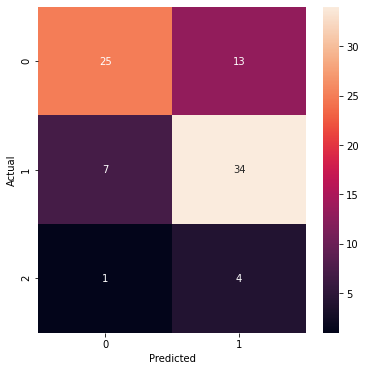

In [49]:
utils.plot_cm(df_dev)

In [50]:
df_dev.loc[df_dev['label'] == 2]

,wsi,label,vote_0,vote_1,vote_2,pred,correct
79,../input/histopathology-dataset/dev/MESO/TCGA-...,2,0,11,0,1,False
80,../input/histopathology-dataset/dev/MESO/TCGA-...,2,0,11,0,1,False
81,../input/histopathology-dataset/dev/MESO/TCGA-...,2,0,11,0,1,False
82,../input/histopathology-dataset/dev/MESO/TCGA-...,2,4,7,0,1,False
83,../input/histopathology-dataset/dev/MESO/TCGA-...,2,6,5,0,0,False


In [51]:
print("Accuracy: {:.1%}".format(
    sum(df_dev['correct']) / len(df_dev)
))

Accuracy: 70.2%
